In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import ParameterGrid
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_excel('GS4.xlsx')
df.sample(2)

,Year,Question
185,2013,What do you understand by the following terms ...
191,2013,What is ‘emotional intelligence’ and how can i...


In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
from nltk import pos_tag
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
import re
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\et_ii\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

In [4]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    
    question_words = {'explain', 'what', 'when', 'where', 'who', 'whom', 'which', 'why', 'how', 
                        'comment', 'discuss','following', 'example', 
                        'examine', 'state', 'critically','context', 'measures', 
                        'suggest', 'evaluate', 'describe', 'identify', 'illustrate','can','could','should',
                        'do','does','would','did','will','might'}
    stop_words.update(question_words)
    stop_words = list(stop_words)
    
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r' +', ' ', text)
    
    text = word_tokenize(text)
    filtered_sentence = [w for w in text if not w in stop_words]
    text = ' '.join(filtered_sentence)
    
    def lemmatize_sentence(sentence):
        nltk_tagged = pos_tag(nltk.word_tokenize(sentence))
        
        def nltk2wn_tag(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:          
                return None
    
        wordnet_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        return " ".join(lemmatized_sentence)
    return lemmatize_sentence(text)
    

In [5]:
text = df.Question[0]
print(text)
filtered_text = preprocess(text)
print(filtered_text)

What do you understand by ‘moral integrity’ and ‘professional efficiency in the context of corporate governance in India ? Illustrate with suitable examples.
understand moral integrity professional efficiency corporate governance india suitable example


In [8]:
def bert_model(df):
    questions = df['Question'].values.tolist()
    lemmatized_questions = [preprocess(question) for question in questions]
    
    param_grid = {
        'n_gram_range': [(1, 2), (1, 3),(1,4)],
        'questions': [lemmatized_questions, questions],
        'embedding_model': ['all-mpnet-base-v2', 'all-MiniLM-L6-v2'],
    }
    
    best_params = None
    best_outliers = float('inf')
    outliers_list = []
    
    representation = [PartOfSpeech("en_core_web_sm"),MaximalMarginalRelevance(diversity=0.2),KeyBERTInspired(top_n_words=30)]
    iteration = 0
    for params in ParameterGrid(param_grid):
        iteration+=1
        print(f"Iteration: {iteration}")
        # print(params)
        sentence_model = SentenceTransformer(params['embedding_model'])
        ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)
        model = BERTopic(embedding_model=sentence_model,representation_model=representation,ctfidf_model=ctfidf_model,verbose=True,calculate_probabilities=True, nr_topics=7, n_gram_range=params['n_gram_range'], min_topic_size=3)
        topics, probs = model.fit_transform(params['questions'])
        
        unique_topics = len(set(topics)) - (1 if -1 in topics else 0)
        
        if unique_topics < 5 :
            continue
        
        outliers_count  = sum(1 for topic in topics if topic == -1)
        outliers_list.append(outliers_count)
        print(f"Outliers: {outliers_count}")
        
        if(outliers_count < best_outliers):
            best_outliers = outliers_count
            best_params = params
            print(f"Best Outliers: {best_outliers}")
            model.save('gs4_model_v2')
            if(best_outliers < 20):
                break

In [9]:
bert_model(df)

Iteration: 1


2024-09-07 09:39:34,198 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
2024-09-07 09:39:39,350 - BERTopic - Embedding - Completed ✓
2024-09-07 09:39:39,350 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:39:45,635 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:39:45,635 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:39:45,652 - BERTopic - Cluster - Completed ✓
2024-09-07 09:39:45,652 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:39:53,371 - BERTopic - Representation - Completed ✓
2024-09-07 09:39:53,371 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:39:58,929 - BERTopic - Topic reduction - Reduced number of topics from 17 to 7
2024-09-07 09:39:58,952 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the envir

Outliers: 35
Best Outliers: 35
Iteration: 2


2024-09-07 09:40:02,166 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]
2024-09-07 09:40:11,794 - BERTopic - Embedding - Completed ✓
2024-09-07 09:40:11,794 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:40:13,273 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:40:13,273 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:40:13,304 - BERTopic - Cluster - Completed ✓
2024-09-07 09:40:13,324 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:40:24,235 - BERTopic - Representation - Completed ✓
2024-09-07 09:40:24,235 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:40:31,294 - BERTopic - Topic reduction - Reduced number of topics from 16 to 7
2024-09-07 09:40:31,336 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the envir

Outliers: 29
Best Outliers: 29
Iteration: 3


2024-09-07 09:40:34,215 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]
2024-09-07 09:40:40,773 - BERTopic - Embedding - Completed ✓
2024-09-07 09:40:40,773 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:40:42,060 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:40:42,060 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:40:42,073 - BERTopic - Cluster - Completed ✓
2024-09-07 09:40:42,077 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:40:52,530 - BERTopic - Representation - Completed ✓
2024-09-07 09:40:52,531 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:40:59,511 - BERTopic - Topic reduction - Reduced number of topics from 16 to 7


Outliers: 35
Iteration: 4


2024-09-07 09:41:01,512 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]
2024-09-07 09:41:11,376 - BERTopic - Embedding - Completed ✓
2024-09-07 09:41:11,376 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:41:13,682 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:41:13,682 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:41:13,697 - BERTopic - Cluster - Completed ✓
2024-09-07 09:41:13,698 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:41:24,694 - BERTopic - Representation - Completed ✓
2024-09-07 09:41:24,694 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:41:32,266 - BERTopic - Topic reduction - Reduced number of topics from 15 to 7


Outliers: 36
Iteration: 5


2024-09-07 09:41:34,515 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]
2024-09-07 09:41:41,278 - BERTopic - Embedding - Completed ✓
2024-09-07 09:41:41,278 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:41:43,017 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:41:43,017 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:41:43,017 - BERTopic - Cluster - Completed ✓
2024-09-07 09:41:43,032 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:41:54,294 - BERTopic - Representation - Completed ✓
2024-09-07 09:41:54,294 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:42:01,392 - BERTopic - Topic reduction - Reduced number of topics from 17 to 7


Outliers: 37
Iteration: 6


2024-09-07 09:42:03,395 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]
2024-09-07 09:42:13,086 - BERTopic - Embedding - Completed ✓
2024-09-07 09:42:13,086 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:42:15,052 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:42:15,052 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:42:15,067 - BERTopic - Cluster - Completed ✓
2024-09-07 09:42:15,083 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:42:25,131 - BERTopic - Representation - Completed ✓
2024-09-07 09:42:25,131 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:42:33,001 - BERTopic - Topic reduction - Reduced number of topics from 12 to 7


Outliers: 29
Iteration: 7


2024-09-07 09:42:35,177 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]
2024-09-07 09:42:36,270 - BERTopic - Embedding - Completed ✓
2024-09-07 09:42:36,270 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:42:37,883 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:42:37,883 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:42:37,899 - BERTopic - Cluster - Completed ✓
2024-09-07 09:42:37,899 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:42:40,319 - BERTopic - Representation - Completed ✓
2024-09-07 09:42:40,319 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:42:42,466 - BERTopic - Topic reduction - Reduced number of topics from 15 to 7
2024-09-07 09:42:42,487 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the envir

Outliers: 24
Best Outliers: 24
Iteration: 8


2024-09-07 09:42:45,678 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]
2024-09-07 09:42:46,699 - BERTopic - Embedding - Completed ✓
2024-09-07 09:42:46,699 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-07 09:42:49,269 - BERTopic - Dimensionality - Completed ✓
2024-09-07 09:42:49,269 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-07 09:42:49,284 - BERTopic - Cluster - Completed ✓
2024-09-07 09:42:49,284 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-07 09:42:52,083 - BERTopic - Representation - Completed ✓
2024-09-07 09:42:52,085 - BERTopic - Topic reduction - Reducing number of topics
2024-09-07 09:42:53,840 - BERTopic - Topic reduction - Reduced number of topics from 16 to 7
2024-09-07 09:42:53,874 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the envir

Outliers: 19
Best Outliers: 19


In [10]:
model = BERTopic.load('gs4_model_v2')

In [11]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19,-1_resolving ethical_ethical values_ethics_eth...,"[resolving ethical, ethical values, ethics, et...","[In recent times, there has been an increasing..."
1,0,74,0_officer_department_government_the government,"[officer, department, government, the governme...",[Rakesh was working as a Joint Commissioner in...
2,1,42,1_civil servants_civil servant_public servants...,"[civil servants, civil servant, public servant...","[Our attitudes towards life, work, other peopl..."
3,2,33,2_three quotations_quotations of_these quotati...,"[three quotations, quotations of, these quotat...",[Given below are three quotations of great mor...
4,3,26,3_does ethics_ethics_ethics and_ethical values,"[does ethics, ethics, ethics and, ethical valu...","[At the international level, bilateral relatio..."
5,4,10,4_emotional intelligence_is emotional_of emoti...,"[emotional intelligence, is emotional, of emot...",[In case of crisis of conscience does emotiona...
6,5,4,5_interest conflict_public interest_interest s...,"[interest conflict, public interest, interest ...",[What is mean by conflict of interest? Illustr...


In [12]:
questions = df['Question'].values.tolist()

In [13]:
model.visualize_documents(questions)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'hovertext': array(['In the context of work environment, differentiate between ‘coercion’ and ‘undue influence’ with suitable examples.',
                                  'Suppose one of your close friends, who is also aspiring for civil services, comes to you for discussing some of the issues related to ethical conduct in public service. He raises the following points:- (i)In the present times, when unethical environment is quite prevalent, individual attempts to stick to ethical principles may cause a lot of problems in one’s career. It may cause hardship to the family members as well as risk to one’s life. Why should we not be pragmatic and follow the path of least resistance, and be happy with doing whatever good we can? (ii) When so many people are adopting wrong means and are grossly harming the system, what difference would it make if only a small minority tries to be ethical? They are going t be rather ineffective and are bound to get frustrated. (iii) If we become fussy about ethical considerations, will it not\nhamper the economic progress of our country?\nAfter all in the present age of high competition we\ncannot afford to be left behind in the race of\ndevelopment (iv) It is understandable that we\nshould not get involved in grossly unethical\npractices, but giving and accepting small\ngratifications and doing small favours increases\neverybody’s motivation. It also makes the system\nmore efficient. What is wrong in adopting such\npractices? Critically analyze the above\nviewpoints. On the basis of this analysis, what\nwill be your advice to your friend?',
                                  'Explain the basic principles of citizens charter movement and bring out its importance',
                                  '“Max Webar said that it is not wise to apply to public administration the sort of moral and ethical norms we apply to matters of personal conscience. It is important to realize that the state bureaucracy might possess its own independent bureaucratic morality.” Critically analyse this statement',
                                  'Discuss the role of ethics and values in enhancing the following three major components of Comprehensive National Power (CNP) viz. human capital, soft power (culture and policies) and social harmony',
                                  'Write short notes on the following in 30 words each : (i) Constitutional morality (ii) Conflict of interest (iii) Probity in public life (iv) Challenges of digitalization (v) Devotion to duty',
                                  'Increased national wealth did not result in equitable distribution of its benefits. It has created only some “enclaves of modernity and prosperity for a small minority at the cost of the majority.” Justify.',
                                  'The current society is plagued with widespread trust-deficit. What are the consequences of this situation for personal well-being and for societal well-being? What can you do at the personal level to make yourself trustworthy?',
                                  'Discipline generally implies following the order and subordination. However, it may be counter-productive for the organisation. Discuss.',
                                  'In recent times, there has been an increasing concern in India to develop effective civil service ethics, code of conduct, transparency measures, ethics and integrity systems and anti-corruption agencies. In view of this, there is a need being felt to focus on three specific areas, which are directly relevant to the problems of internalizing integrity and ethics in the civil services. These are as follows: Anticipating specific threats to ethical standards\nand integrity in the civil services,\nStrengthening the ethical competence of civil\nservants and\nDeveloping administrative processes and\npractices which promote ethical values and\nintegrity in civil services.\nSuggest institutional measures

In [14]:
model.get_representative_docs()

{-1: ['In recent times, there has been an increasing concern in India to develop effective civil service ethics, code of conduct, transparency measures, ethics and integrity systems and anti-corruption agencies. In view of this, there is a need being felt to focus on three specific areas, which are directly relevant to the problems of internalizing integrity and ethics in the civil services. These are as follows: Anticipating specific threats to ethical standards\nand integrity in the civil services,\nStrengthening the ethical competence of civil\nservants and\nDeveloping administrative processes and\npractices which promote ethical values and\nintegrity in civil services.\nSuggest institutional measures to address the\nabove three issues.',
  'In a modern democratic polity, there is a concept of the political executive and permanent executive. Elected people’s representatives form the political executive and bureaucracy forms the permanent executive. Ministers frame policy decisions a

In [15]:
num_words = 10
topics_ = []
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        top_words = " ".join(top_words)
        topics_.append(f"Topic {topic_num}: {top_words}")

len(model.get_topics())

7

In [16]:
topics_

['Topic 0: resolving ethical ethical values ethics ethics and ethical constitutional morality bureaucracy of bureaucracy integrity in to ethical',
 'Topic 1: officer department government the government district situation action issues senior being',
 'Topic 2: civil servants civil servant public servants accountability public servant responsibility contrasting attitudes ethical servants the civil',
 'Topic 3: three quotations quotations of these quotations quotations quotations bring moral thinkers mahatma gandhi philosophers for great moral thinkers philosophers',
 'Topic 4: does ethics ethics ethics and ethical values ethics in ethical ethics seek of ethical of ethics environmental ethics',
 'Topic 5: emotional intelligence is emotional of emotional emotional conscience conscience how emotions taking ethical intelligence practices anger',
 'Topic 6: interest conflict public interest interest situation interest what interest and interest are interest interest illustrate public sector

In [17]:
topic_names = {0:'Outliers',1:'Governmental Actions and Issues',2:'Accountability and Responsibility in Civil Service',3:' Quotations from Moral Thinkers',4:'Environmental and Ethical Values',5:'Emotional Intelligence and Ethical Practices',6:'Conflicts of Interest in the Public Sector'}
num_words = 10
topics_ = {}
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        topics_[topic_names[topic_num]] = top_words

In [18]:
topics_

{'Outliers': ['resolving ethical',
  'ethical values',
  'ethics',
  'ethics and',
  'ethical',
  'constitutional morality',
  'bureaucracy',
  'of bureaucracy',
  'integrity in',
  'to ethical'],
 'Governmental Actions and Issues': ['officer',
  'department',
  'government',
  'the government',
  'district',
  'situation',
  'action',
  'issues',
  'senior',
  'being'],
 'Accountability and Responsibility in Civil Service': ['civil servants',
  'civil servant',
  'public servants',
  'accountability',
  'public servant',
  'responsibility',
  'contrasting attitudes',
  'ethical',
  'servants',
  'the civil'],
 ' Quotations from Moral Thinkers': ['three quotations',
  'quotations of',
  'these quotations',
  'quotations',
  'quotations bring',
  'moral thinkers',
  'mahatma gandhi',
  'philosophers for',
  'great moral',
  'thinkers philosophers'],
 'Environmental and Ethical Values': ['does ethics',
  'ethics',
  'ethics and',
  'ethical values',
  'ethics in',
  'ethical',
  'ethics 

In [19]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
question_embeddings = sbert_model.encode(questions)

topic_embeddings = {}
for i in range(len(topics_.items())):
    topic_embeddings[topic_names[i]] = []
    for word in topics_[topic_names[i]]:
        topic_embeddings[topic_names[i]].append(sbert_model.encode(word))
        
topic_embeddings

{'Outliers': [array([ 6.44354373e-02,  1.06394172e-01,  2.01183259e-02,  4.36957739e-02,
         -6.10273741e-02, -1.47693064e-02,  1.13618858e-02,  1.97599754e-02,
         -9.63812415e-03, -1.40908826e-03, -9.38632526e-03,  3.24180424e-02,
         -2.64350208e-03,  1.32633783e-02, -1.31872687e-02,  2.24485174e-02,
         -1.40626188e-02,  1.71422530e-02,  6.33240640e-02, -2.08961200e-02,
          6.66596042e-03,  1.06962037e-03,  4.38904725e-02, -1.30360546e-02,
          9.24217701e-03, -3.00942268e-02,  4.62602004e-02, -1.51760504e-02,
          3.26841325e-02,  4.36818115e-02,  3.18958424e-02, -6.14602910e-03,
         -4.83579747e-03, -1.34899560e-02,  1.40165514e-06, -3.56461480e-02,
         -4.03980818e-03,  4.76878090e-03,  4.66032838e-03,  2.96315178e-03,
          3.73637564e-02, -2.29650130e-03, -1.17400168e-02,  7.73116108e-03,
         -1.92091055e-02,  4.79804687e-02,  5.78221073e-03,  3.93855013e-02,
          2.87868246e-03,  3.95378880e-02, -1.56597197e-02,  2.7

In [20]:
from sentence_transformers import CrossEncoder
crossencoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


In [21]:
question = questions[77]
topics_nearest = []
for i in range(len(topics_.items())):
    for word in topics_[topic_names[i]]:
        score = crossencoder.predict([(question,word)])
        topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})

topics_nearest

[{'Outliers': [-9.581594467163086, 'resolving ethical']},
 {'Outliers': [-9.904521942138672, 'ethical values']},
 {'Outliers': [-9.237470626831055, 'ethics']},
 {'Outliers': [-9.400447845458984, 'ethics and']},
 {'Outliers': [-9.004849433898926, 'ethical']},
 {'Outliers': [-9.393686294555664, 'constitutional morality']},
 {'Outliers': [-9.960655212402344, 'bureaucracy']},
 {'Outliers': [-9.75786018371582, 'of bureaucracy']},
 {'Outliers': [-9.842388153076172, 'integrity in']},
 {'Outliers': [-9.155884742736816, 'to ethical']},
 {'Governmental Actions and Issues': [-9.708642959594727, 'officer']},
 {'Governmental Actions and Issues': [-9.47938060760498, 'department']},
 {'Governmental Actions and Issues': [-9.320535659790039, 'government']},
 {'Governmental Actions and Issues': [-9.415336608886719, 'the government']},
 {'Governmental Actions and Issues': [-9.753057479858398, 'district']},
 {'Governmental Actions and Issues': [-9.192803382873535, 'situation']},
 {'Governmental Actions an

In [22]:
topics_nearest.sort(key=lambda x: list(x.values())[0],reverse=True)
top_7_nearest = topics_nearest[:7]
top_7_nearest

[{'Emotional Intelligence and Ethical Practices': [-5.066099166870117,
   'conscience']},
 {'Emotional Intelligence and Ethical Practices': [-5.677871227264404,
   'conscience how']},
 {'Conflicts of Interest in the Public Sector': [-8.381784439086914,
   'public interest']},
 {'Conflicts of Interest in the Public Sector': [-8.423538208007812,
   'public sector']},
 {'Accountability and Responsibility in Civil Service': [-8.490962028503418,
   'public servants']},
 {'Accountability and Responsibility in Civil Service': [-8.604415893554688,
   'public servant']},
 {'Outliers': [-9.004849433898926, 'ethical']}]

In [23]:
highest_scores = {}

for entry in topics_nearest:
    for topic, (score, word) in entry.items():
        if topic not in highest_scores or score > highest_scores[topic][0]:
            highest_scores[topic] = (score, word)

total = sum(score for score,word in highest_scores.values())



closest_topics = {topic:(score/total , word) for topic,(score,word) in highest_scores.items()}


closest_topics

{'Emotional Intelligence and Ethical Practices': (0.08643063346133081,
  'conscience'),
 'Conflicts of Interest in the Public Sector': (0.14299817566622464,
  'public interest'),
 'Accountability and Responsibility in Civil Service': (0.14486080959861158,
  'public servants'),
 'Outliers': (0.153628031185309, 'ethical'),
 'Environmental and Ethical Values': (0.153628031185309, 'ethical'),
 'Governmental Actions and Issues': (0.15509233697649613, 'being'),
 ' Quotations from Moral Thinkers': (0.16336198192671886, 'moral thinkers')}

In [24]:
def score_generate(question):
    topics_nearest = []
    for i in range(len(topics_.items())):
        for word in topics_[topic_names[i]]:
            score = crossencoder.predict([(question,word)])
            topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})
    
    highest_scores = {}
    for entry in topics_nearest:
        for topic, (score, word) in entry.items():
            if topic not in highest_scores or score > highest_scores[topic][0]:
                highest_scores[topic] = (score, word)

    total = sum(score for score,word in highest_scores.values())
    closest_topics = {topic:(score/total) for topic,(score,word) in highest_scores.items()}
    return closest_topics

In [25]:
data = pd.DataFrame()

for i in range(len(questions)):
    data_ = pd.DataFrame(score_generate(questions[i]),index=[i])
    data_['Question'] = questions[i]
    
    data = pd.concat([data,data_],ignore_index=True)

In [29]:
data.sample(5)


,Outliers,Governmental Actions and Issues,Accountability and Responsibility in Civil Service,Quotations from Moral Thinkers,Environmental and Ethical Values,Emotional Intelligence and Ethical Practices,Conflicts of Interest in the Public Sector,Question,Topic,Year
158,0.144281,0.135975,0.137777,0.145871,0.148054,0.148234,0.139808,You are the Sarpanch of a Panchayat. There is ...,Governmental Actions and Issues,2015
80,0.139229,0.113593,0.139229,0.162837,0.139229,0.154954,0.150929,What do you understand by probity in governanc...,Governmental Actions and Issues,2019
187,0.154482,0.147509,0.088661,0.180112,0.154482,0.162762,0.111992,What do you understand by the following terms ...,Accountability and Responsibility in Civil Ser...,2013
79,0.140557,0.140153,0.140557,0.148564,0.140557,0.147080,0.142530,There is a view that the Official Secrets Act ...,Governmental Actions and Issues,2019
51,0.139371,0.146428,0.139854,0.147967,0.139371,0.139413,0.147598,An elevated corridor is being constructed to r...,Outliers,2021


In [ ]:
data['Topic'] = data.iloc[:,:-1].idxmin(axis=1)
data['Year'] = df['Year']
data.sample(5)

In [31]:
data.to_excel('GS4_topics_v2.xlsx', index=False)

In [32]:
data = pd.read_excel('GS4_topics_v2.xlsx')

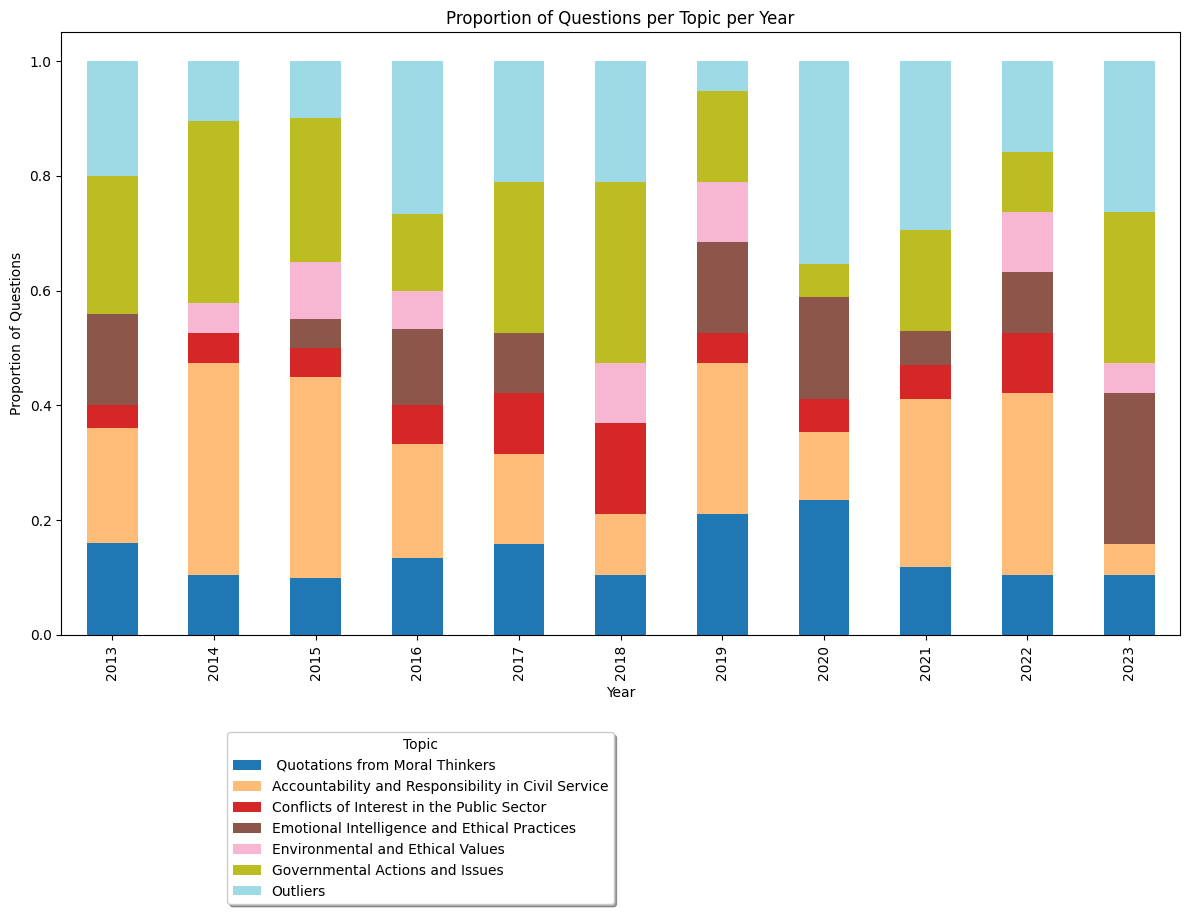

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Step 2: Count questions per topic per year
topic_year_counts = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

# Calculate the total number of questions per year
total_questions_per_year = topic_year_counts.groupby('Year')['Count'].transform('sum')

# Calculate the proportion of questions per topic per year
topic_year_counts['Proportion'] = topic_year_counts['Count'] / total_questions_per_year

# Step 3: Prepare data for plotting (normalized)
pivot_table = topic_year_counts.pivot(index='Year', columns='Topic', values='Proportion')

# Generate a list of colors from a colormap
num_topics = len(pivot_table.columns)
colors = plt.get_cmap('tab20', num_topics)

# Step 4: Plot the normalized data with different colors for each topic
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(num_topics)])

# Step 5: Customize the plot
plt.xlabel('Year')
plt.ylabel('Proportion of Questions')
plt.title('Proportion of Questions per Topic per Year')
plt.legend(title='Topic', loc='best', bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

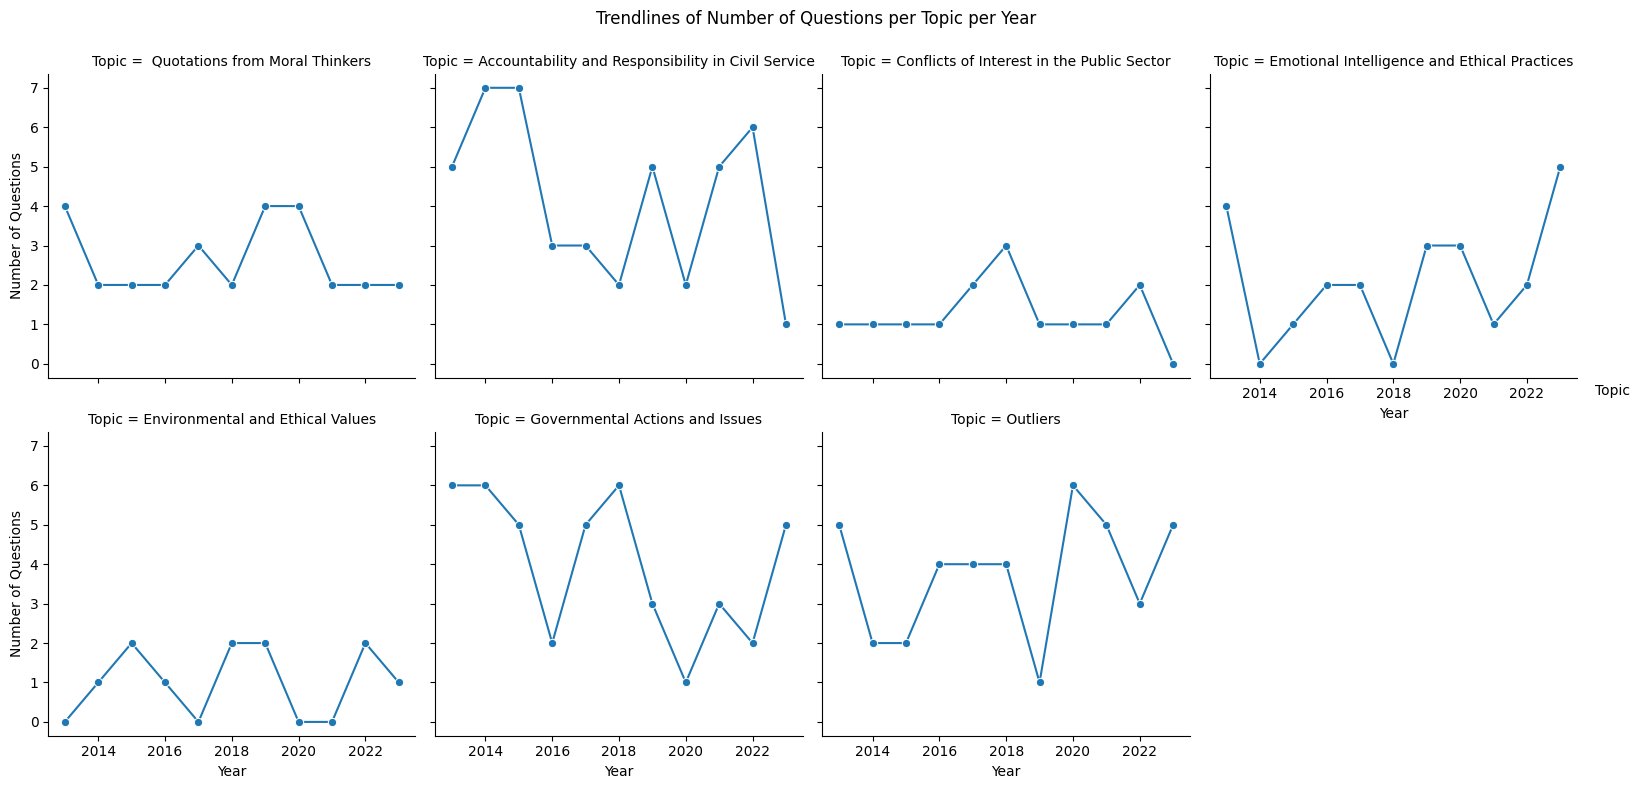

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

topic_year_counts = pd.crosstab(data['Year'], data['Topic'])

# Reset index to convert the pivot table to a DataFrame
topic_year_counts = topic_year_counts.reset_index()

# Melt the DataFrame to long format for Seaborn
melted_topic_year_counts = topic_year_counts.melt(id_vars='Year', var_name='Topic', value_name='Count')


g = sns.FacetGrid(melted_topic_year_counts, col='Topic', col_wrap=4, height=4, sharex=True, sharey=True)
g.map(sns.lineplot, 'Year', 'Count', marker='o')
g.set_axis_labels('Year', 'Number of Questions')
g.add_legend(title='Topic')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Trendlines of Number of Questions per Topic per Year')
plt.show()


<Axes: title={'center': 'Topic Frequency'}, xlabel='Topics', ylabel='Number Of Questions'>

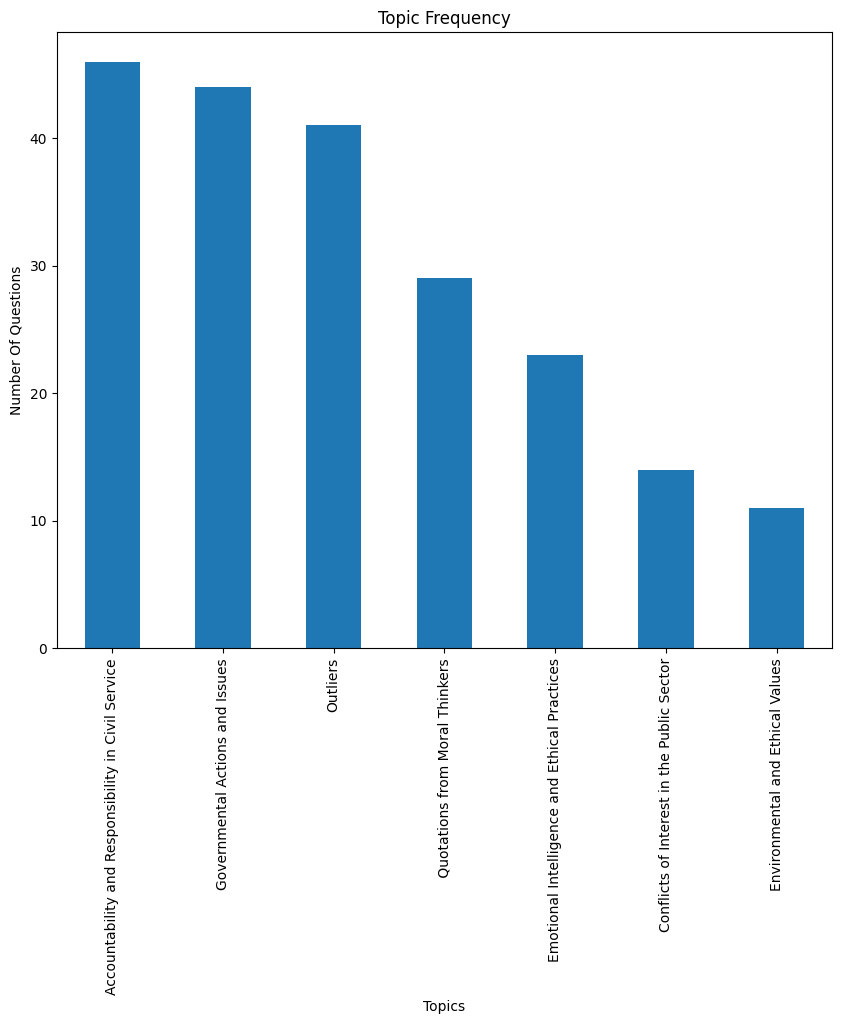

In [36]:
data.Topic.value_counts().plot(kind='bar', figsize=(10, 8), title='Topic Frequency', xlabel='Topics', ylabel='Number Of Questions', rot=90)